In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/data_processed.csv')
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,Dependents_No,Dependents_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingMovies_No,...,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,SeniorCitizen_0,SeniorCitizen_1,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes
0,1,29.85,29.85,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
1,34,56.95,1889.50,0,1,0,1,0,0,1,...,0,1,1,0,0,1,0,1,0,0
2,2,53.85,108.15,1,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,0,0,0,1,1,...,0,1,1,0,0,1,0,1,0,0
4,2,70.70,151.65,1,1,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,0


In [3]:
def train_model(data, a_range, model=None, params=None, useSMOTE=False):
    x = data.drop('Churn',axis=1).values
    y = data['Churn'].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=1)
    
    if useSMOTE:
        sm = SMOTE(random_state=1)
        x_train, y_train = sm.fit_sample(x_train, y_train.ravel())
    
    a = 0.05
    train_scores = []
    test_scores = []
    
    clf = None
    
    for a in a_range:
        train_size = int(round(x_train.shape[0] * a))
        sub_x_train = x_train[:train_size]
        sub_y_train = y_train[:train_size]

        clf = GridSearchCV(model, params, scoring='f1', cv=5)
        clf.fit(sub_x_train, sub_y_train)
        
        p, r, fscore_train, s = precision_recall_fscore_support(sub_y_train, 
                                                                clf.predict(sub_x_train), 
                                                                average='binary')
        p, r, fscore_test, s = precision_recall_fscore_support(y_test, 
                                                               clf.predict(x_test), 
                                                               average='binary')
        
        train_scores.append(fscore_train)
        test_scores.append(fscore_test)
        
    test_accuracy = sum(clf.predict(x_test) == y_test) / x_test.shape[0]
        
    return train_scores, test_scores, clf.best_params_, test_accuracy

In [4]:
def model_analysis(data, a_range, model=None, params=None, useSMOTE=False):
    
    train_scores, test_scores, best_params, test_accuracy = train_model(data, a_range, model, params, useSMOTE)
      
    plt.plot(a_range, train_scores, '.r-', label='F Score Train')
    plt.plot(a_range, test_scores, '.b-', label='F Score Test')
    plt.legend()
    plt.xlabel('Fraction of train data available')
    plt.ylabel('F Score')
    plt.yticks(np.arange(0.5,0.78,0.02))
    plt.grid()
    plt.show()
    
    print('Best model parameters: \t', best_params, '\nTest Accuracy: \t', test_accuracy)

# Logistic Regression

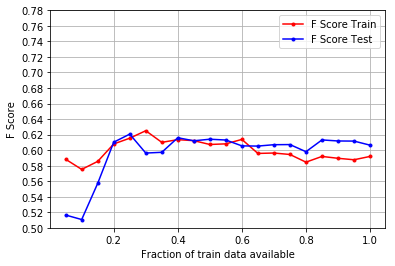

Best model parameters: 	 {'C': 0.1} 
Test Accuracy: 	 0.808329389493611


In [5]:
params = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,4,5,10,20,40]}
model_analysis(df, 
               a_range=np.arange(0.05,1.01,0.05), 
               model=LogisticRegression(random_state=1), 
               params=params)

## Removing highly correlated predictors

In [6]:
# Code in this cell was created based on the information from the following source:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# Create correlation matrix
corr_matrix = df.drop('Churn',axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Dropping
df2 = df.drop(to_drop, axis=1)

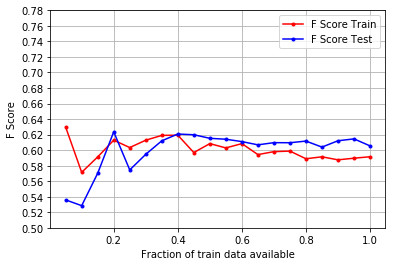

Best model parameters: 	 {'C': 0.05} 
Test Accuracy: 	 0.8088026502602934


In [7]:
params = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,4,5,10,20,40]}
model_analysis(df2, 
               a_range=np.arange(0.05,1.01,0.05), 
               model=LogisticRegression(random_state=1), 
               params=params)

## Standartizing the data

In [8]:
df2.loc[:,['tenure', 'MonthlyCharges', 'TotalCharges']].head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [9]:
scaler = StandardScaler()
#cols=['tenure', 'MonthlyCharges', 'TotalCharges']
cols = df2.drop('Churn', axis=1).columns
for col in cols:
    df2[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df2[col])),columns=[col])

In [10]:
df2.loc[:,['tenure', 'MonthlyCharges', 'TotalCharges','SeniorCitizen_1']].head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_1
0,-1.277445,-1.160323,-0.994242,NaN
1,0.066327,-0.259629,-0.173244,NaN
2,-1.236724,-0.362660,-0.959674,NaN
3,0.514251,-0.746535,-0.194766,NaN
4,-1.236724,0.197365,-0.940470,NaN


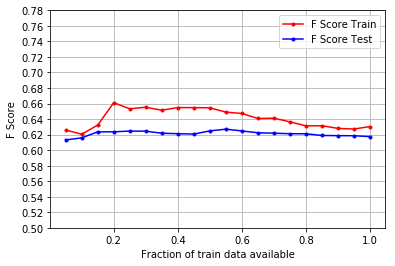

Best model parameters: 	 {'C': 0.001} 
Test Accuracy: 	 0.779460482725982


In [11]:
params = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,4,5,10,20,40]}
model_analysis(df2, 
               a_range=np.arange(0.05,1.01,0.05), 
               model=LogisticRegression(random_state=1), 
               params=params)

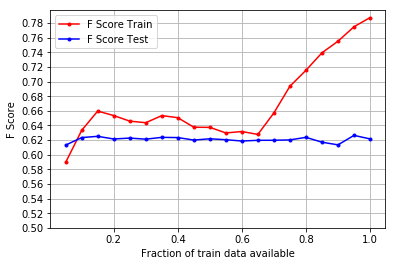

Best model parameters: 	 {'C': 4} 
Test Accuracy: 	 0.7458589682915286


In [12]:
params = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,4,5,10,20,40]}
model_analysis(df2, 
               a_range=np.arange(0.05,1.01,0.05), 
               model=LogisticRegression(random_state=1), 
               params=params,
               useSMOTE=True)

# XGBoost

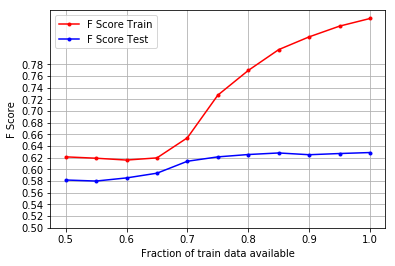

Best model parameters: 	 {} 
Test Accuracy: 	 0.7827733080927591


In [13]:
params = dict()
model_analysis(df2, 
               a_range=np.arange(0.5,1.01,0.05), 
               model=XGBClassifier(random_state=1), 
               params=params,
               useSMOTE=True)

# SVM

In [14]:
# For canonical SVM format
df2['Churn'] = df2['Churn'].apply(lambda x: -1 if x == 0 else 1)

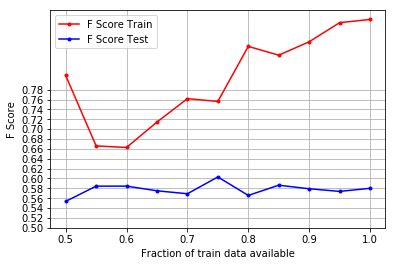

Best model parameters: 	 {'C': 10} 
Test Accuracy: 	 0.7553241836251775


In [15]:
params = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,4,5,10,20,40]}
model_analysis(df2, 
               a_range=np.arange(0.5,1.01,0.05), 
               model=SVC(random_state=1), 
               params=params,
               useSMOTE=True)

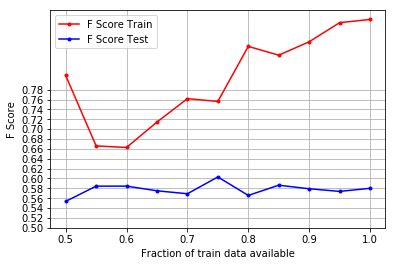

Best model parameters: 	 {'C': 10} 
Test Accuracy: 	 0.7553241836251775


In [16]:
params = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,4,5,10,20,40]}
model_analysis(df2, 
               a_range=np.arange(0.5,1.01,0.05), 
               model=SVC(kernel='rbf', random_state=1), 
               params=params,
               useSMOTE=True)

## Feature Importance

In [17]:
# For canonical Logistic Regression format
df2['Churn'] = df2['Churn'].apply(lambda x: 1 if x == 1 else 0)

data = df2
x = data.drop('Churn',axis=1).values
y = data['Churn'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=1)

sm = SMOTE(random_state=1)
x_train, y_train = sm.fit_sample(x_train, y_train.ravel())

In [18]:
model=LogisticRegression(C=0.001, random_state=1)

model.fit(x_train, y_train);

In [19]:
def plot_importances(columns, importances):
    plt.rcParams.update({'font.size': 15})
    y_pos = np.arange(columns.shape[0]);

    fig, ax = plt.subplots(figsize=(10,14));
    ax.grid(zorder=0)
    ax.barh(y_pos, importances, align='center');
    ax.set_yticks(y_pos);
    ax.set_yticklabels(columns);

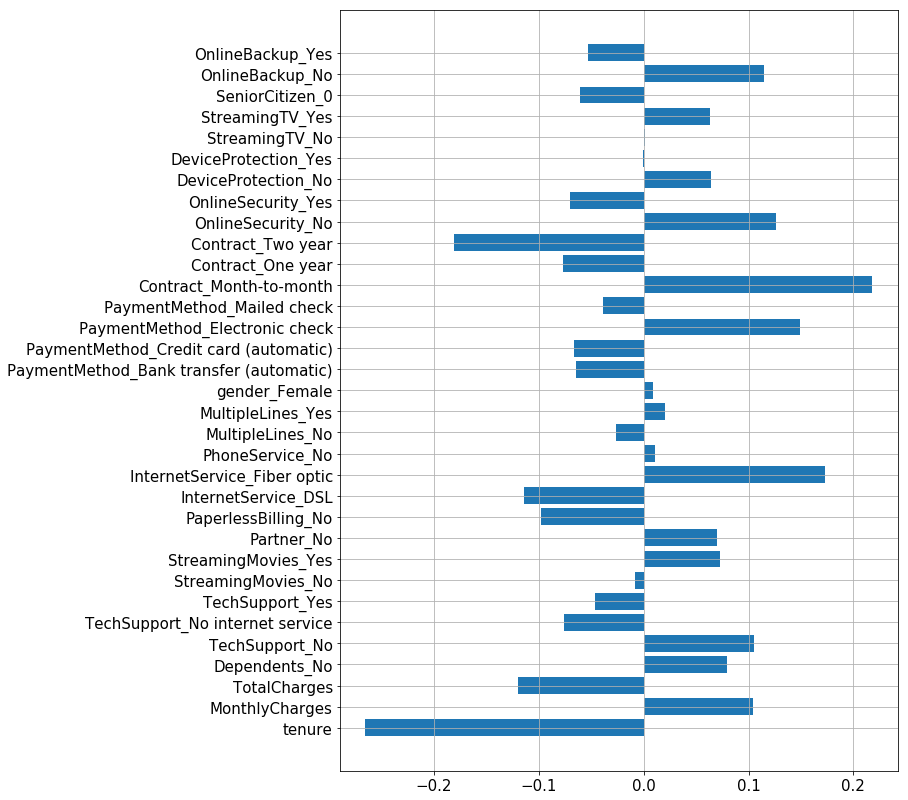

In [20]:
importances = model.coef_[0];
columns = df2.drop(['Churn'],axis=1).columns.values;
plot_importances(columns, importances)

In [21]:
model=XGBClassifier(random_state=1)
model.fit(x_train, y_train);

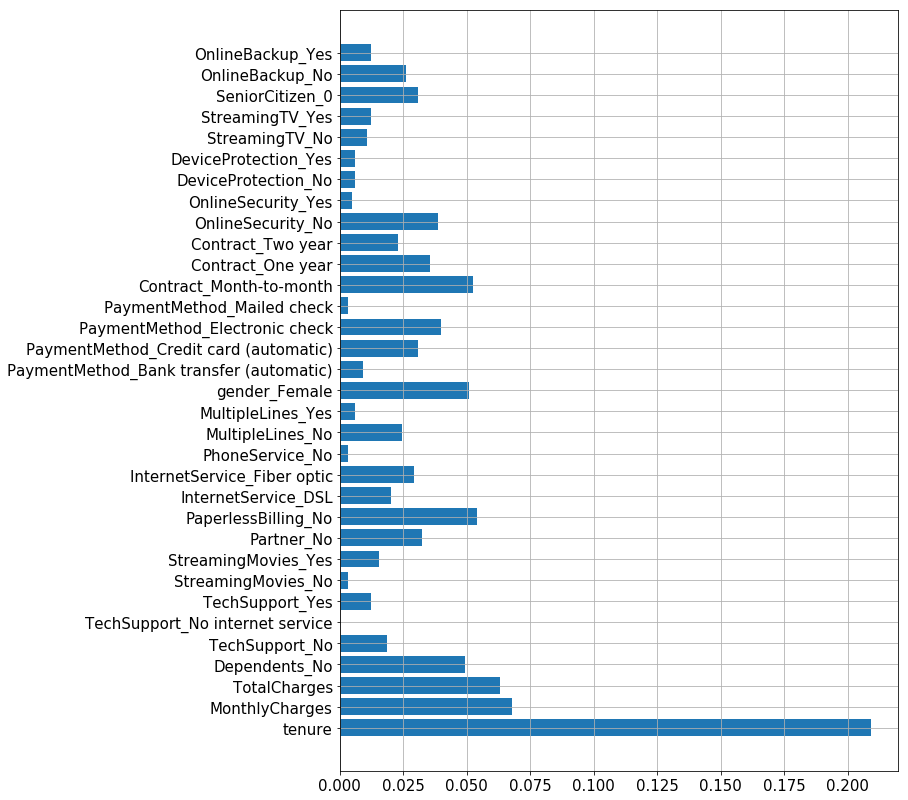

In [22]:
importances = model.feature_importances_
columns = df2.drop(['Churn'],axis=1).columns.values
plot_importances(columns, importances)